In [1]:
import csv
import math
import ast
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

In [2]:
def read_eos_geometry(filename):
    row_x = 1
    row_y = 2
    row_z = 3
    
    #Read CSV
    df = pd.read_csv(filename)
    
    matrix = df.to_numpy()

    #Extract cylindrical Coordinate
    r_cylindrical = np.sqrt(matrix[:, row_x]**2 + matrix[:, row_z]**2)
    theta_cylindrical = np.arctan2(matrix[:, row_y], matrix[:, row_x]) * -180 / np.pi + 180
    theta_degrees = theta_cylindrical * 180 / math.pi

    #Make df columns for cylindrical
    df['R Length'] = r_cylindrical
    df['Theta'] = theta_cylindrical
    df['Height'] = matrix[:, row_z]
    
    height = matrix[:, row_z]
    return df
    
read_eos_geometry('metaData.csv')

,PMT ID,X Position,Y Position,Z Position,R Length,Theta,Height
0,0,-681.965000,-390.919000,-991.096000,1203.057581,330.177612,-991.096000
1,1,-736.027000,-138.561000,-1116.930000,1337.635365,349.338543,-1116.930000
2,2,-697.283000,131.268000,-1026.750000,1241.136231,10.661517,-1026.750000
3,3,-681.965000,390.919000,-991.096000,1203.057581,29.822388,-991.096000
4,4,-477.826000,-546.650000,-1126.764000,1223.893295,311.156661,-1126.764000
...,...,...,...,...,...,...,...
236,236,285.518401,814.309562,1066.501827,1104.059285,109.322011,1066.501827
237,237,582.819656,-658.263043,1058.728087,1208.546198,228.478636,1058.728087
238,238,607.948537,-333.708127,1137.230690,1289.532887,208.762758,1137.230690
239,239,616.402121,0.000000,1163.639680,1316.817709,180.000000,1163.639680


In [12]:
#Credit to Eli Brunner-Huber for the bulk of this code
def read_annie_geometry(filename):
        
    # Step 1: Read the CSV file
    df = pd.read_csv('FullTankPMTGeometry.csv')
    
    # Step 2: Drop the first 4 rows and the last row
    df = df.iloc[3:-1]  # .iloc to slice, starting from the 5th row to the second-to-last row
    
    # Step 3: Select the first, fifth, sixth, and seventh columns
    selected_columns = df.iloc[:, [0, 4, 5, 6]]  # 0, 4, 5, and 6 are the indices for the first, fifth, sixth, and seventh columns
    
    # Step 4: Convert the selected columns to numeric values
    selected_columns = selected_columns.apply(pd.to_numeric, errors='coerce')  # Converts columns to numeric types
    selected_columns.columns = ['PMT ID', 'X Position', 'Y Position', 'Z Position']

    annie_geo = selected_columns
    # Step 5: Convert the selected columns to a matrix (numpy array)
    matrix = selected_columns.to_numpy()
    
    # Step 6: Add .1446 to the third column (index 2) and -1.681 to the fourth column (index 3)
    matrix[:, 2] += 0.1446  # Add .1446 to the third column (index 2)
    matrix[:, 3] += -1.681  # Add -1.681 to the fourth column (index 3)
    
    # Step 7: Calculate cylindrical coordinates
    # r = sqrt(x^2 + z^2)
    r_cylindrical = np.sqrt(matrix[:, 1]**2 + matrix[:, 3]**2)  # matrix[:, 1] is x, matrix[:, 3] is z

    # theta = atan2(z, x) (angle in the xy-plane)
    theta_cylindrical = np.arctan2(matrix[:, 3], matrix[:, 1])  # matrix[:, 3] is z, matrix[:, 1] is x
    
    # y = height (directly taken from the third column)
    height = matrix[:, 2]  # matrix[:, 2] is y, which is the height

    annie_geo['R Length'] = r_cylindrical
    annie_geo['Theta'] = theta_cylindrical
    annie_geo['Height'] = height

    return annie_geo

read_annie_geometry('FullTankPMTGeometry.csv')

,PMT ID,X Position,Y Position,Z Position,R Length,Theta,Height
3,332,-0.643413,-1.693962,2.000517,0.718381,2.680671,-1.549362
4,333,-0.247685,-1.693962,1.603793,0.259439,-2.839422,-1.549362
5,334,-0.775424,-1.693962,1.508324,0.794418,-2.922482,-1.549362
6,335,-0.445549,-1.693962,1.802155,0.461728,2.876090,-1.549362
7,336,-0.577560,-1.685249,1.309961,0.686473,-2.570562,-1.540649
...,...,...,...,...,...,...,...
130,459,0.920851,0.864528,2.244969,1.079827,0.549519,1.009128
131,460,-0.266620,0.862612,2.728097,1.080509,1.820126,1.007212
132,461,0.549892,0.863099,2.608747,1.078469,1.035748,1.007699
133,462,0.264898,0.010389,2.724132,1.076242,1.322108,0.154989


In [13]:
#Use a PMT to get its position
def id_to_geo(id, geometry):
    id_list = geometry.iloc[:,0].to_numpy()
    for i in range(0, len(id_list)):
        if id_list[i] == id:
            return geometry.iloc[i,:].to_numpy()
        else:
            continue

In [14]:
#Read the data and make an array of events where each event has some hits of the formate [ID, Time, Charge]
def read_data(filename):
    #Load data
    df = pd.read_csv(filename)
    event_numbers = df.iloc[:,0]
    
    all_events = []
    #Loop by each row where row is event
    for i in range(0, len(event_numbers)):
        ncolumns = len(df.iloc[i,:])
        if(ncolumns > 4):
            print("WTF")
        Nhits = len(json.loads(df.iloc[i,1]))
        event = []
        #loop through the entries in a given column
        for j in range(0, Nhits-1):
            AHit = [json.loads(df.iloc[i,1])[j], json.loads(df.iloc[i,2])[j], json.loads(df.iloc[i,3])[j]]
            event.append(AHit)
        all_events.append(event)
    return all_events
    

In [18]:
#Takes a hit, geometry, and 'Canvas' and plots it on the canvas
def plot_hit(hit, data_index, collab_name, geometry, axes):
    ax0, ax1, ax2 = axes
    #Sort hard-coded values by collaboration
    if collab_name.lower() == 'eos':
        max_height = 1000
        min_height = -750
        end_cap_min_x = -900
        end_cap_max_x = 900
        end_cap_min_y = end_cap_min_x
        end_cap_max_y = end_cap_max_x
        x_ind = 1
        y_ind = 2
        height_ind = 3
        theta_ind = 5
    elif collab_name.lower() == 'annie':
        max_height = 1.1
        min_height = -1.3
        end_cap_min_x = 0.5
        end_cap_max_x = 2.75
        end_cap_min_y = -1
        end_cap_max_y = 1
        x_ind = 3
        y_ind = 1
        height_ind = 6
        theta_ind = 5
    else:
        print("Unsupported Collaboration Name")
        return 0
        
    #Load meta data
    event_pos = id_to_geo(hit[0], geometry)
    x_pos = event_pos[x_ind]
    y_pos = event_pos[y_ind]
    height = event_pos[height_ind]
    theta_cylindrical = event_pos[theta_ind]

    norm = mcolors.Normalize(vmin=0,vmax=1)

    #Create the figure
    if height < max_height and height > min_height:
        #Plot the Barrel
        ax1.scatter(theta_cylindrical, height, c=hit[data_index], norm=norm, cmap='viridis', marker='o', label='PMT locations', s=300)
        ax1.set_title('Unfolded Cylindrical Barrel View')
        ax1.set_xlabel('Theta (radians) - Angle Around the Cylinder')
        ax1.set_ylabel('Height (y) - Vertical Position in Tank')
        
    #Plot the Top End Cap
    elif height > max_height:
        ax0.set_xlim(end_cap_min_x, end_cap_max_x)
        ax0.set_ylim(end_cap_min_y, end_cap_max_y)
        ax0.scatter(x_pos, y_pos, c=hit[data_index], cmap='viridis', norm=norm, marker='o', label='PMT locations', s=360)
        ax0.set_title('Top End Cap Heat Map')
        ax0.set_xlabel('X Position (mm)')
        ax0.set_ylabel('Y position (mm)')

    elif height < min_height:
        #Plot the Bottom End Cap
        ax2.set_xlim(end_cap_min_x, end_cap_max_x)
        ax2.set_ylim(end_cap_min_y, end_cap_max_y)
        ax2.scatter(x_pos, y_pos, c=hit[data_index], cmap='viridis', norm=norm, marker='o', label='PMT locations', s=200)
        ax2.set_title('Bottom End Cap Heat Map')
        ax2.set_xlabel('X Position (mm)')
        ax2.set_ylabel('Y position (mm)')



In [19]:
#Sample ANNIE loop() to plot all events 
annie_data = read_data("annieLaser4692.csv")
annie_geo = read_annie_geometry("FullTankPMTGeometry.csv")

with PdfPages('annie.pdf') as pdf:
    #Crashes around 62, does not have geometry for PMT 332  
    for i in tqdm(range(0, len(annie_data))):
        #Initialize a "Canvas"
        fig = plt.figure(figsize=(10,10), layout="constrained")
        spec = fig.add_gridspec(2,2)
        ax0 = fig.add_subplot(spec[1,0])
        ax1 = fig.add_subplot(spec[0,:])
        ax2 = fig.add_subplot(spec[1,1])

        #Loop over each event per 
        for j in range(0, len(annie_data[i])):
            plot_hit(annie_data[i][j], 1, 'annie', annie_geo, (ax0,ax1,ax2))
            
        pdf.savefig(fig)
        plt.close()
  
            

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:02<00:00,  3.21it/s]


In [20]:
#Sample Eos loop() to plot all events 
eos_data = read_data("outputData.csv")
eos_geo = read_eos_geometry("eosMetaMap.csv")

with PdfPages('eos.pdf') as pdf:
    for i in tqdm(range(0,len(eos_data))):
        fig = plt.figure(figsize=(10,10), layout="constrained")
        spec = fig.add_gridspec(2,2)
        ax0 = fig.add_subplot(spec[1,0])
        ax1 = fig.add_subplot(spec[0,:])
        ax2 = fig.add_subplot(spec[1,1])
        
        for j in range(0, len(eos_data[i])):
            plot_hit(eos_data[i][j], 1, 'eos', eos_geo, (ax0,ax1,ax2))
            
        pdf.savefig(fig)
        plt.close()
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:25<00:00,  2.35it/s]


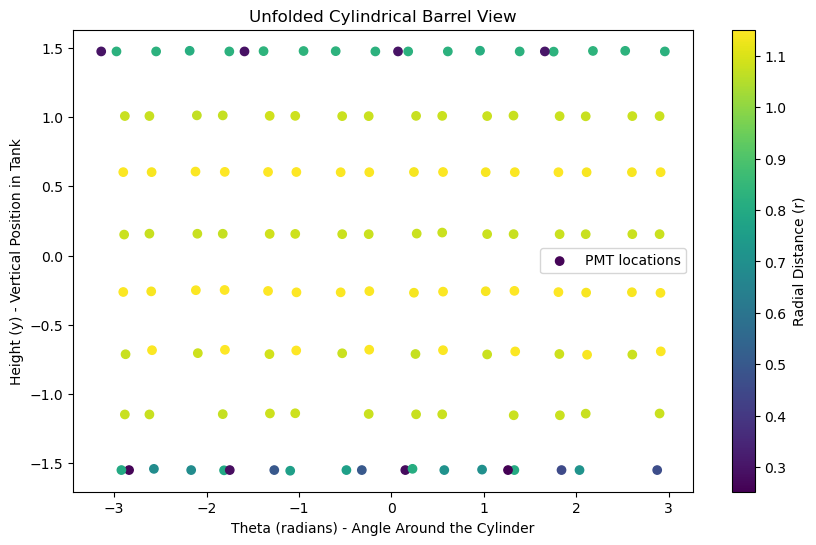

In [12]:
#Code from Eli that helped motivate the event display code above
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the CSV file
df = pd.read_csv('FullTankPMTGeometry.csv')


# Step 2: Drop the first 4 rows and the last row
df = df.iloc[4:-1]  # .iloc to slice, starting from the 5th row to the second-to-last row

# Step 3: Select the first, fifth, sixth, and seventh columns
selected_columns = df.iloc[:, [0, 4, 5, 6]]  # 0, 4, 5, and 6 are the indices for the first, fifth, sixth, and seventh columns

# Step 4: Convert the selected columns to numeric values
selected_columns = selected_columns.apply(pd.to_numeric, errors='coerce')  # Converts columns to numeric types

# Step 5: Convert the selected columns to a matrix (numpy array)
matrix = selected_columns.to_numpy()

# Step 6: Add .1446 to the third column (index 2) and -1.681 to the fourth column (index 3)
matrix[:, 2] += 0.1446  # Add .1446 to the third column (index 2)
matrix[:, 3] += -1.681  # Add -1.681 to the fourth column (index 3)

# Step 7: Calculate cylindrical coordinates
# r = sqrt(x^2 + z^2)
r_cylindrical = np.sqrt(matrix[:, 1]**2 + matrix[:, 3]**2)  # matrix[:, 1] is x, matrix[:, 3] is z

# theta = atan2(z, x) (angle in the xy-plane)
theta_cylindrical = np.arctan2(matrix[:, 3], matrix[:, 1])  # matrix[:, 3] is z, matrix[:, 1] is x

# y = height (directly taken from the third column)
height = matrix[:, 2]  # matrix[:, 2] is y, which is the height

# Step 8: Plotting the unfolded cylindrical barrel

# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Plot the PMT locations on the unfolded cylindrical barrel
# We use theta as the x-axis (representing the angle around the cylinder) and r as the y-axis (radial distance from the center)
plt.scatter(theta_cylindrical, height, c=r_cylindrical, cmap='viridis', marker='o', label='PMT locations')

# Add labels and title
plt.title('Unfolded Cylindrical Barrel View')
plt.xlabel('Theta (radians) - Angle Around the Cylinder')
plt.ylabel('Height (y) - Vertical Position in Tank')
plt.colorbar(label='Radial Distance (r)')
plt.legend()

# Show the plot
plt.show()
